In [4]:
import glob, os
import numpy as np
from PIL import Image

In [5]:
import torch
import torch.nn as nn
from torchvision.transforms import CenterCrop
from torch.nn import functional as F
import albumentations as A
from albumentations.pytorch import ToTensorV2


from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from imutils import paths
import cv2
from tqdm import tqdm
from matplotlib import pyplot as plt
import time

# Data preparation

In [3]:
image_file_names = {'test':[], 'train':[], 'val':[]}
for folder in glob.glob("images" + '/*'):
    for filename in glob.glob(folder + "/*.jpg"):
        folder_name=folder.split('\\')[-1]
        image_file_names[folder_name].append(filename)
    print(f"images in {folder_name}: ", len(image_file_names[folder_name]))


images in test:  10
images in train:  47
images in val:  40


In [6]:
# define the path to the images and masks dataset
IMAGE_DATASET_PATH = os.path.join("cars_train", "train_images")
MASK_DATASET_PATH = os.path.join("cars_train", "train_mask")


TEST_PATH = os.path.join("cars_test", "test_images" )
TEST_MASKS = os.path.join("cars_test", "test_mask")

# define the validation split
TEST_SPLIT = 0.15
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [74]:
# define the number of channels in the input, number of classes,
# and number of levels in the U-Net model
NUM_CHANNELS = 3
NUM_CLASSES = 1
NUM_LEVELS = 3
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 0.0001
NUM_EPOCHS = 40
BATCH_SIZE = 9
# define the input image dimensions
INPUT_IMAGE_WIDTH = 256
INPUT_IMAGE_HEIGHT = 256
# define threshold to filter weak predictions
THRESHOLD = 0.5
# define the path to the base output directory
BASE_OUTPUT = "output"
# define the path to the output serialized model, model training
# plot, and testing image paths
MODEL_PATH = os.path.join(BASE_OUTPUT, "rod_model.pth")
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])

### Define custom dataset for segmentation

In [54]:
class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths, transforms):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths
		self.transforms = transforms

	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)

	def __getitem__(self, idx):

		# grab the image path from the current index
		imagePath = self.imagePaths[idx]
		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		# image = np.array(Image.open(self.imagePath).convert("RGB"))
        # mask = np.array(Image.open(self.maskPaths[idx]).convert("L"), dtype=np.float32)
        # mask[mask == 255.0] = 1.0
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		mask = cv2.imread(self.maskPaths[idx], 0)
		#gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
		# _, mask = cv2.threshold(mask, 0, 1, cv2.THRESH_BINARY)
		mask[mask == 255.0] = 1.0


		# check to see if we are applying any transformations
		if self.transforms is not None:
			# apply the transformations to both image and its mask
			augmentations=self.transforms(image=image, mask=mask)
			image = augmentations["image"]
			mask = augmentations["mask"]
			mask[mask > 0] = 1.0
		# return a tuple of the image and its mask
		return (image, mask)

### U-net model architecture

In [9]:
class Block(nn.Module):
	def __init__(self, inChannels, outChannels):
		super().__init__()
		# store the convolution and RELU layers
		self.conv1 = nn.Conv2d(inChannels, outChannels, kernel_size=3)
		self.relu = nn.ReLU()
		self.conv2 = nn.Conv2d(outChannels, outChannels, kernel_size=3)

	def forward(self, x):
		# apply CONV => RELU => CONV block to the inputs and return it
		return self.conv2(self.relu(self.conv1(x)))

In [10]:
class Encoder(nn.Module):
	def __init__(self, channels=(3, 64, 128, 256, 512)):
		super().__init__()
		# store the encoder blocks and maxpooling layer
		self.encBlocks = nn.ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
		self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
		self.bottleneck = Block(channels[-1], channels[-1]*2)


	def forward(self, x):
		# initialize an empty list to store the intermediate outputs
		blockOutputs = []
		# loop through the encoder blocks
		for block in self.encBlocks:
			# pass the inputs through the current encoder block, store
			# the outputs, and then apply maxpooling on the output
			x = block(x)
			blockOutputs.append(x)
			x = self.pool(x)

		x = self.bottleneck(x)
		# return the list containing the intermediate outputs
		return blockOutputs, x

In [11]:
class Decoder(nn.Module):
	def __init__(self, channels=(1024, 512, 256, 128, 64)):
		super().__init__()
		# initialize the number of channels, upsampler blocks, and
		# decoder blocks
		self.channels = channels
		self.upconvs = nn.ModuleList(
			[nn.ConvTranspose2d(channels[i], channels[i + 1], kernel_size=2, stride=2)
			 	for i in range(len(channels) - 1)])
		self.dec_blocks = nn.ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])

	def forward(self, x, encFeatures):
		#do first upsampling from 1024 to 512 channels
		# x = nn.ConvTranspose2d(2*self.channels[0], self.channels[0], kernel_size=2, stride=2)
		# loop through the number of channels
		for i in range(len(self.channels) - 1):
			# pass the inputs through the upsampler blocks
			x = self.upconvs[i](x)
			# crop the current features from the encoder blocks,
			# concatenate them with the current upsampled features,
			# and pass the concatenated output through the current
			# decoder block
			encFeat = self.crop(encFeatures[i], x)
			x = torch.cat([x, encFeat], dim=1)
			x = self.dec_blocks[i](x)
		# return the final decoder output
		return x

	def crop(self, encFeatures, x):
		# grab the dimensions of the inputs, and crop the encoder
		# features to match the dimensions
		(_, _, H, W) = x.shape
		encFeatures = CenterCrop([H, W])(encFeatures)
		# return the cropped features
		return encFeatures

In [12]:
class UNet(nn.Module):
	def __init__(self, encChannels=(3, 64, 128, 256, 512),
		 decChannels=(1024, 512, 256, 128, 64),
		 nbClasses=1, retainDim=True,
		 outSize=(INPUT_IMAGE_HEIGHT,  INPUT_IMAGE_WIDTH)):
		super().__init__()
		# initialize the encoder and decoder
		self.encoder = Encoder(encChannels)
		self.decoder = Decoder(decChannels)
		# initialize the regression head and store the class variables
		self.head = nn.Conv2d(decChannels[-1], nbClasses, 1)
		self.retainDim = retainDim
		self.outSize = outSize


	def forward(self, x):
		# grab the features from the encoder
		encFeatures, x = self.encoder(x)
		# pass the encoder features through decoder making sure that
		# their dimensions are suited for concatenation
		decFeatures = self.decoder(x, encFeatures[::-1])
		# pass the decoder features through the regression head to
		# obtain the segmentation mask
		map = self.head(decFeatures)
		# check to see if we are retaining the original output
		# dimensions and if so, then resize the output to match them
		if self.retainDim:
			map = F.interpolate(map, self.outSize)
		# return the segmentation map
		return map

In [ ]:
def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )

    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()

### Training

In [120]:
# load the image and mask filepaths in a sorted manner
imagePaths = sorted(list(paths.list_images(IMAGE_DATASET_PATH)))
maskPaths = sorted(list(paths.list_images(MASK_DATASET_PATH)))

testPath = sorted(list(paths.list_images(TEST_PATH)))
testMaskPath = sorted(list(paths.list_images(TEST_MASKS)))
# partition the data into training and testing splits using 85% of
# the data for training and the remaining 15% for validation
split = train_test_split(imagePaths, maskPaths, test_size=TEST_SPLIT, random_state=42)

In [14]:
# unpack the data split
(trainImages, valImages) = split[:2]
(trainMasks, valMasks) = split[2:]

In [15]:
len(trainMasks)

81

In [119]:
len(valImages)

15

In [121]:
len(testPath)

12

In [16]:
train_transforms = A.Compose(
        [
            A.Resize(height=INPUT_IMAGE_WIDTH, width=INPUT_IMAGE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

val_transforms = A.Compose(
        [
            A.Resize(height=INPUT_IMAGE_WIDTH, width=INPUT_IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

In [122]:
# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks,
	transforms=train_transforms)
valDS = SegmentationDataset(imagePaths=valImages, maskPaths=valMasks,
    transforms=val_transforms)

testDS = SegmentationDataset(imagePaths=testPath, maskPaths=testMaskPath,
	transforms=val_transforms)


print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(valDS)} examples in the validation set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")

[INFO] found 81 examples in the training set...
[INFO] found 15 examples in the validation set...
[INFO] found 12 examples in the test set...


In [123]:
# create the training and test data loaders
trainLoader = DataLoader(trainDS, shuffle=True, batch_size=BATCH_SIZE)
valLoader = DataLoader(valDS, shuffle=False, batch_size=BATCH_SIZE)
testLoader = DataLoader(testDS, shuffle=False, batch_size=len(testDS))

In [110]:
image, mask = next(iter(trainLoader))

In [111]:
mask.shape

torch.Size([9, 256, 256])

In [112]:
mask[0].max()

tensor(1, dtype=torch.uint8)

### Initialize model

In [113]:
# initialize our UNet model
unet = UNet().to(DEVICE)
# initialize loss function and optimizer
lossFunc = nn.BCEWithLogitsLoss()

opt = torch.optim.Adam(unet.parameters(), lr=INIT_LR)

# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // BATCH_SIZE
valSteps = len(valDS) // BATCH_SIZE
# initialize a dictionary to store training history
H = {"train_loss": [], "val_loss": []}

In [114]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
train_acc=[]
val_acc=[]
for e in tqdm(range(NUM_EPOCHS)):
	# set the model in training mode
	unet.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalValLoss = 0
	# loop over the training set
	num_correct = 0
	num_pixels = 0
	dice_score = 0
	for (i, (x, y)) in enumerate(trainLoader):
		# send the input to the device
		(x, y) = (x.to(DEVICE), y.to(DEVICE))
		y = y.to(torch.float32).squeeze()

		# perform a forward pass and calculate the training loss
		pred = unet(x).squeeze().to(torch.float32)

		loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss

		#compute metrics
		pred = torch.sigmoid(pred)
		pred =(pred > 0.5).float()
		num_correct += (pred == y).sum()
		num_pixels += torch.numel(pred)
		dice_score += (2 * (pred * y).sum())/((pred + y).sum() + 1e-8)

	print(f"Train accuracy: {num_correct/num_pixels:.2f} Dice score: {dice_score/len(trainLoader):.2f}")
	train_acc.append(num_correct / num_pixels)


	num_correct = 0
	num_pixels = 0
	dice_score = 0
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		unet.eval()
		# loop over the validation set
		for (x, y) in valLoader:
			# send the input to the device
			(x, y) = (x.to(DEVICE), y.to(DEVICE))
			y = y.to(torch.float32)
			# make the predictions and calculate the validation loss
			pred = unet(x).squeeze().to(torch.float32)
			totalValLoss += lossFunc(pred, y)

			#compute metrics
			pred = torch.sigmoid(pred)
			pred = (pred > 0.5).float()
			num_correct += (pred == y).sum()
			num_pixels += torch.numel(pred)
			dice_score += (2 * (pred * y).sum()) / ((pred + y).sum() + 1e-8)

	print(f"Val accuracy: {num_correct/num_pixels:.2f} Dice score: {dice_score/len(trainLoader):.2f}")

	val_acc.append(num_correct/num_pixels)
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgValLoss = totalValLoss / valSteps
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["val_loss"].append(avgValLoss.cpu().detach().numpy())
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
	print("Train loss: {:.6f}, Val loss: {:.4f}".format(avgTrainLoss, avgValLoss))
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

[INFO] training the network...


  0%|          | 0/40 [00:00<?, ?it/s]

Train accuracy: 0.34 Dice score: 0.29


  2%|▎         | 1/40 [00:41<27:05, 41.67s/it]

Val accuracy: 0.76 Dice score: 0.01
[INFO] EPOCH: 1/40
Train loss: 0.705384, Val loss: 1.3479
Train accuracy: 0.78 Dice score: 0.00


  5%|▌         | 2/40 [01:31<29:17, 46.25s/it]

Val accuracy: 0.80 Dice score: 0.00
[INFO] EPOCH: 2/40
Train loss: 0.616121, Val loss: 1.1135
Train accuracy: 0.79 Dice score: 0.00


  8%|▊         | 3/40 [02:16<28:09, 45.66s/it]

Val accuracy: 0.80 Dice score: 0.00
[INFO] EPOCH: 3/40
Train loss: 0.562496, Val loss: 1.0604
Train accuracy: 0.79 Dice score: 0.00


 10%|█         | 4/40 [02:58<26:43, 44.53s/it]

Val accuracy: 0.80 Dice score: 0.00
[INFO] EPOCH: 4/40
Train loss: 0.550805, Val loss: 1.0592
Train accuracy: 0.79 Dice score: 0.00


 12%|█▎        | 5/40 [03:41<25:40, 44.01s/it]

Val accuracy: 0.80 Dice score: 0.00
[INFO] EPOCH: 5/40
Train loss: 0.535040, Val loss: 1.0180
Train accuracy: 0.79 Dice score: 0.00


 15%|█▌        | 6/40 [04:24<24:41, 43.57s/it]

Val accuracy: 0.80 Dice score: 0.00
[INFO] EPOCH: 6/40
Train loss: 0.517987, Val loss: 0.9995
Train accuracy: 0.79 Dice score: 0.00


 18%|█▊        | 7/40 [05:07<23:47, 43.25s/it]

Val accuracy: 0.80 Dice score: 0.00
[INFO] EPOCH: 7/40
Train loss: 0.504941, Val loss: 0.9901
Train accuracy: 0.79 Dice score: 0.00


 20%|██        | 8/40 [05:50<22:58, 43.09s/it]

Val accuracy: 0.80 Dice score: 0.00
[INFO] EPOCH: 8/40
Train loss: 0.497897, Val loss: 0.9846
Train accuracy: 0.79 Dice score: 0.00


 22%|██▎       | 9/40 [06:33<22:15, 43.09s/it]

Val accuracy: 0.80 Dice score: 0.00
[INFO] EPOCH: 9/40
Train loss: 0.493692, Val loss: 0.9605
Train accuracy: 0.79 Dice score: 0.00


 25%|██▌       | 10/40 [07:15<21:25, 42.85s/it]

Val accuracy: 0.80 Dice score: 0.00
[INFO] EPOCH: 10/40
Train loss: 0.486921, Val loss: 0.9275
Train accuracy: 0.79 Dice score: 0.00


 28%|██▊       | 11/40 [07:57<20:39, 42.73s/it]

Val accuracy: 0.80 Dice score: 0.00
[INFO] EPOCH: 11/40
Train loss: 0.458163, Val loss: 0.8931
Train accuracy: 0.79 Dice score: 0.10


 30%|███       | 12/40 [08:40<19:56, 42.72s/it]

Val accuracy: 0.79 Dice score: 0.11
[INFO] EPOCH: 12/40
Train loss: 0.427584, Val loss: 0.8213
Train accuracy: 0.80 Dice score: 0.52


 32%|███▎      | 13/40 [09:23<19:12, 42.68s/it]

Val accuracy: 0.81 Dice score: 0.13
[INFO] EPOCH: 13/40
Train loss: 0.408459, Val loss: 0.8023
Train accuracy: 0.79 Dice score: 0.48


 35%|███▌      | 14/40 [10:05<18:30, 42.69s/it]

Val accuracy: 0.81 Dice score: 0.13
[INFO] EPOCH: 14/40
Train loss: 0.410823, Val loss: 0.7581
Train accuracy: 0.81 Dice score: 0.48


 38%|███▊      | 15/40 [10:50<18:02, 43.30s/it]

Val accuracy: 0.81 Dice score: 0.09
[INFO] EPOCH: 15/40
Train loss: 0.395349, Val loss: 0.7642
Train accuracy: 0.81 Dice score: 0.39


 40%|████      | 16/40 [11:33<17:13, 43.07s/it]

Val accuracy: 0.83 Dice score: 0.14
[INFO] EPOCH: 16/40
Train loss: 0.391121, Val loss: 0.7243
Train accuracy: 0.81 Dice score: 0.34


 42%|████▎     | 17/40 [12:15<16:27, 42.94s/it]

Val accuracy: 0.81 Dice score: 0.12
[INFO] EPOCH: 17/40
Train loss: 0.387722, Val loss: 0.7398
Train accuracy: 0.81 Dice score: 0.52


 45%|████▌     | 18/40 [12:58<15:40, 42.75s/it]

Val accuracy: 0.82 Dice score: 0.11
[INFO] EPOCH: 18/40
Train loss: 0.383781, Val loss: 0.6935
Train accuracy: 0.82 Dice score: 0.53


 48%|████▊     | 19/40 [13:40<14:56, 42.70s/it]

Val accuracy: 0.82 Dice score: 0.11
[INFO] EPOCH: 19/40
Train loss: 0.367778, Val loss: 0.7200
Train accuracy: 0.81 Dice score: 0.45


 50%|█████     | 20/40 [14:23<14:13, 42.68s/it]

Val accuracy: 0.81 Dice score: 0.14
[INFO] EPOCH: 20/40
Train loss: 0.377331, Val loss: 0.6954
Train accuracy: 0.81 Dice score: 0.37


 52%|█████▎    | 21/40 [15:05<13:30, 42.68s/it]

Val accuracy: 0.84 Dice score: 0.14
[INFO] EPOCH: 21/40
Train loss: 0.371097, Val loss: 0.6411
Val accuracy: 0.82 Dice score: 0.11
[INFO] EPOCH: 22/40
Train loss: 0.360117, Val loss: 0.7073
Train accuracy: 0.82 Dice score: 0.59


 55%|█████▌    | 22/40 [15:49<12:51, 42.84s/it]

Train accuracy: 0.83 Dice score: 0.52


 57%|█████▊    | 23/40 [16:39<12:48, 45.23s/it]

Val accuracy: 0.84 Dice score: 0.14
[INFO] EPOCH: 23/40
Train loss: 0.358367, Val loss: 0.6314
Train accuracy: 0.83 Dice score: 0.57


 60%|██████    | 24/40 [17:27<12:13, 45.82s/it]

Val accuracy: 0.85 Dice score: 0.14
[INFO] EPOCH: 24/40
Train loss: 0.358545, Val loss: 0.6123
Train accuracy: 0.81 Dice score: 0.49


 62%|██████▎   | 25/40 [18:13<11:27, 45.84s/it]

Val accuracy: 0.85 Dice score: 0.11
[INFO] EPOCH: 25/40
Train loss: 0.376722, Val loss: 0.6726
Train accuracy: 0.82 Dice score: 0.56


 65%|██████▌   | 26/40 [18:56<10:29, 44.99s/it]

Val accuracy: 0.84 Dice score: 0.14
[INFO] EPOCH: 26/40
Train loss: 0.354948, Val loss: 0.6404
Train accuracy: 0.82 Dice score: 0.47


 68%|██████▊   | 27/40 [19:42<09:49, 45.32s/it]

Val accuracy: 0.83 Dice score: 0.14
[INFO] EPOCH: 27/40
Train loss: 0.359027, Val loss: 0.6485
Train accuracy: 0.83 Dice score: 0.61


 70%|███████   | 28/40 [20:29<09:10, 45.89s/it]

Val accuracy: 0.85 Dice score: 0.14
[INFO] EPOCH: 28/40
Train loss: 0.346057, Val loss: 0.6423
Train accuracy: 0.84 Dice score: 0.57


 72%|███████▎  | 29/40 [21:17<08:31, 46.53s/it]

Val accuracy: 0.84 Dice score: 0.15
[INFO] EPOCH: 29/40
Train loss: 0.332592, Val loss: 0.6101
Train accuracy: 0.84 Dice score: 0.63


 75%|███████▌  | 30/40 [22:02<07:40, 46.02s/it]

Val accuracy: 0.86 Dice score: 0.14
[INFO] EPOCH: 30/40
Train loss: 0.320362, Val loss: 0.5749
Train accuracy: 0.85 Dice score: 0.65


 78%|███████▊  | 31/40 [22:47<06:53, 45.91s/it]

Val accuracy: 0.83 Dice score: 0.15
[INFO] EPOCH: 31/40
Train loss: 0.305349, Val loss: 0.6208
Train accuracy: 0.82 Dice score: 0.43


 80%|████████  | 32/40 [23:33<06:06, 45.77s/it]

Val accuracy: 0.84 Dice score: 0.14
[INFO] EPOCH: 32/40
Train loss: 0.362157, Val loss: 0.6833
Train accuracy: 0.82 Dice score: 0.56


 82%|████████▎ | 33/40 [24:20<05:24, 46.31s/it]

Val accuracy: 0.85 Dice score: 0.13
[INFO] EPOCH: 33/40
Train loss: 0.346589, Val loss: 0.6262
Train accuracy: 0.84 Dice score: 0.61


 85%|████████▌ | 34/40 [25:06<04:35, 45.96s/it]

Val accuracy: 0.85 Dice score: 0.15
[INFO] EPOCH: 34/40
Train loss: 0.330737, Val loss: 0.5764
Train accuracy: 0.84 Dice score: 0.61


 88%|████████▊ | 35/40 [25:50<03:47, 45.57s/it]

Val accuracy: 0.87 Dice score: 0.15
[INFO] EPOCH: 35/40
Train loss: 0.326606, Val loss: 0.5441
Train accuracy: 0.83 Dice score: 0.58


 90%|█████████ | 36/40 [26:37<03:03, 45.84s/it]

Val accuracy: 0.86 Dice score: 0.15
[INFO] EPOCH: 36/40
Train loss: 0.353745, Val loss: 0.5855
Train accuracy: 0.83 Dice score: 0.60


 92%|█████████▎| 37/40 [27:23<02:17, 45.84s/it]

Val accuracy: 0.82 Dice score: 0.15
[INFO] EPOCH: 37/40
Train loss: 0.327830, Val loss: 0.6461
Train accuracy: 0.83 Dice score: 0.54


 95%|█████████▌| 38/40 [28:28<01:43, 51.85s/it]

Val accuracy: 0.85 Dice score: 0.15
[INFO] EPOCH: 38/40
Train loss: 0.333911, Val loss: 0.6074
Train accuracy: 0.84 Dice score: 0.58


 98%|█████████▊| 39/40 [29:30<00:54, 54.80s/it]

Val accuracy: 0.86 Dice score: 0.15
[INFO] EPOCH: 39/40
Train loss: 0.332926, Val loss: 0.5588
Train accuracy: 0.85 Dice score: 0.65


100%|██████████| 40/40 [30:19<00:00, 45.49s/it]

Val accuracy: 0.87 Dice score: 0.15
[INFO] EPOCH: 40/40
Train loss: 0.311578, Val loss: 0.5520
[INFO] total time taken to train the model: 1819.49s


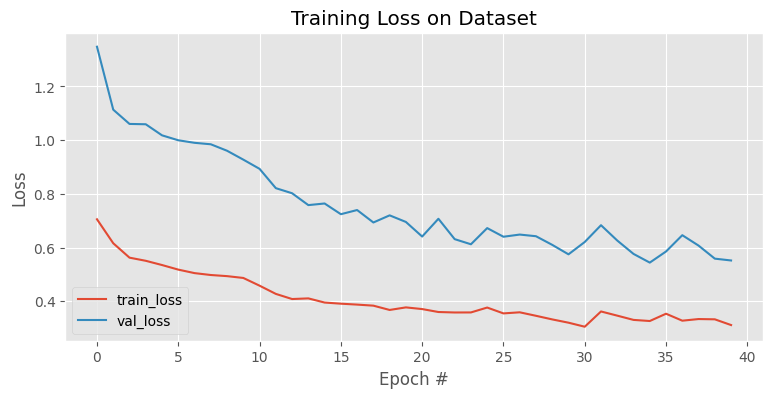

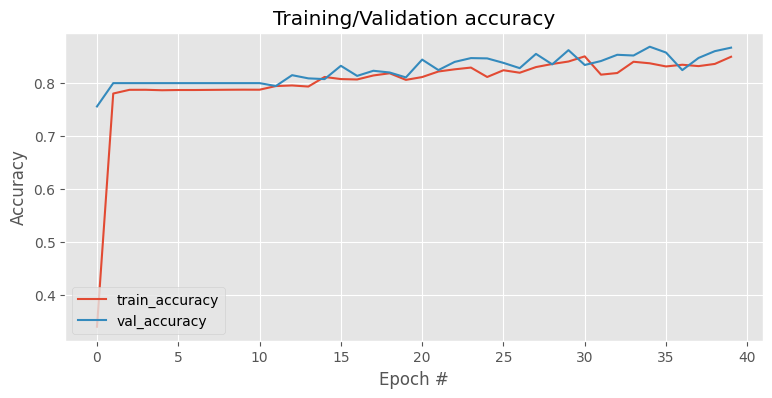

In [115]:
# plot the training loss
plt.style.use("ggplot")
plt.figure(figsize=(9, 4))
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)
# serialize the model to disk
torch.save(unet, MODEL_PATH)

plt.style.use("ggplot")
plt.figure(figsize=(9, 4))
plt.plot(range(len(train_acc)), train_acc, label="train_accuracy")
plt.plot(range(len(val_acc)), val_acc, label="val_accuracy")
plt.title("Training/Validation accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

In [116]:
def prepare_plot(origImage, origMask, predMask):
	# initialize our figure
	figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
	# plot the original image, its mask, and the predicted mask
	ax[0].imshow(origImage)
	ax[1].imshow(origMask)
	ax[2].imshow(predMask)
	# set the titles of the subplots
	ax[0].set_title("Image")
	ax[1].set_title("Original Mask")
	ax[2].set_title("Predicted Mask")
	# set the layout of the figure and display it
	figure.tight_layout()
	figure.show()

In [118]:
def make_predictions(loader, model, device=DEVICE):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            pred = torch.sigmoid(model(x))
            pred = (pred > 0.5).float()
            num_correct += (pred == y).sum()
            num_pixels += torch.numel(pred)
            dice_score += (2 * (pred * y).sum()) / (
                (pred + y).sum() + 1e-8
            )

    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice score: {dice_score/len(loader)}")

In [124]:
make_predictions(testLoader, unet)

Got 674757/786432 with acc 85.80
Dice score: 0.6503523588180542


In [131]:
def plot_predictions(model, imagePath):
	# set model to evaluation mode
	model.eval()
	for image_name in imagePath:
	# turn off gradient tracking
		with torch.no_grad():
			# load the image from disk, swap its color channels, cast it
			# to float data type, and scale its pixel values
			image = cv2.imread(imagePath)
			image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)



			# image =
			# image = image.astype("float32") / 255.0
			# # resize the image and make a copy of it for visualization
			# image = cv2.resize(image, (INPUT_IMAGE_HEIGHT, INPUT_IMAGE_HEIGHT))
			orig = image.copy()
			# find the filename and generate the path to ground truth
			# mask
			filename = (imagePath.split(os.path.sep)[-1].split(".")[0]+"_mask.jpg")
			groundTruthPath = os.path.join(TEST_MASKS,
				filename)
			# load the ground-truth segmentation mask in grayscale mode
			# and resize it
			gtMask = cv2.imread(groundTruthPath, 0)
			# gtMask = cv2.resize(gtMask, (INPUT_IMAGE_HEIGHT, INPUT_IMAGE_HEIGHT))

			augmentations=val_transforms(image=image, mask=gtMask)
			image = augmentations["image"]
			gtMask = augmentations["mask"]

			# make the channel axis to be the leading one, add a batch
			# dimension, create a PyTorch tensor, and flash it to the
			# current device
			#image = np.transpose(image, (2, 0, 1))
			image = np.expand_dims(image, 0)
			image = torch.from_numpy(image).to(DEVICE)
			# make the prediction, pass the results through the sigmoid
			# function, and convert the result to a NumPy array
			predMask = model(image).squeeze()
			predMask = torch.sigmoid(predMask)
			predMask = predMask.cpu().numpy()
			# filter out the weak predictions and convert them to integers
			predMask = (predMask > THRESHOLD) * 255
			predMask = predMask.astype(np.uint8)
			# prepare a plot for visualization
			prepare_plot(orig, gtMask, predMask)

In [132]:
# load our model from disk and flash it to the current device
print("[INFO] load up model...")
unet = torch.load(MODEL_PATH).to(DEVICE)

[INFO] load up model...


In [ ]:
# load the image paths in our testing file and randomly select 10
# image paths
print("[INFO] loading up test image paths...")
for filename in glob.glob(TEST_PATH + "/*.jpg"):
	# make predictions and visualize the results
	plot_predictions(unet, filename)

[INFO] loading up test image paths...


C:\Users\user\AppData\Local\Temp\ipykernel_9388\4085958671.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()
C:\Users\user\AppData\Local\Temp\ipykernel_9388\4085958671.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
